# Data Pre-processing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This cell autoreloads the notebook when you change you python file code.
# If you think the notebook did not reload, rerun this cell.
%load_ext autoreload
%autoreload 2
!pip install jsonlines

In [ ]:
import json
import pandas as pd
import numpy as np
import torch as th
import jsonlines
import nltk

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
device = th.device("cuda")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# trainingdatasetfiles = "/content/yelp_review_training_dataset.jsonl"
# traindata = []
# with open(trainingdatasetfiles, 'r', encoding='utf-8') as f:
#   for item in jsonlines.Reader(f):
#     # print(item)
#     traindata.append(item)
# df_trainingraw = pd.DataFrame(data)

# df_trainingraw = pd.read_json(path_or_buf=trainingdatasetfiles, lines=True)
# df_trainingraw
# df_trainingraw['tokenized_sents'] = df_trainingraw['text'].apply(nltk.word_tokenize)
# df_trainingraw.to_csv("tokenized_trainingentiredf.csv")

Loading the tokenized dataset from previous dataframe. Then doing 70:30 randomized split for the validation and training data since it would take too much computation for k-fold cross validation.

In [ ]:
#path = "/content/drive/MyDrive/182_nlp/tokenized_trainingentiredf.csv"
path = "/dataframes/tokenized_trainingentiredf.csv"
df_trainingraw = pd.read_csv(path)
trainsize = len(df_trainingraw)
indices = np.random.permutation(trainsize)
trainingsize = trainsize - int(trainsize*.30)
train_data = df_trainingraw.iloc[indices][:trainingsize].reset_index(drop=True)
validation_data=df_trainingraw.iloc[indices][:trainingsize][trainingsize:].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train_data.head()
# train_data.to_csv("tokenized_traindf.csv")

,Unnamed: 0,review_id,text,stars,tokenized_sents
0,244548,B8cZ_G1ed12pPwIQ_VgWSA,I wish I had paid attention to my fellow Yelpe...,1.0,"['I', 'wish', 'I', 'had', 'paid', 'attention',..."
1,520683,i8g_RP0k65eldY0BHK4_ng,"Kyle did a fantastic job. For starters, you ca...",5.0,"['Kyle', 'did', 'a', 'fantastic', 'job', '.', ..."
2,194029,igY5-0nyp6vI1kiH2B35vA,In a way I'm glad for all the low reviews here...,4.0,"['In', 'a', 'way', 'I', ""'m"", 'glad', 'for', '..."
3,378177,XGtCPyjfYB0XSd6QcMjZGw,"The worst Uhaul location in the country, they ...",1.0,"['The', 'worst', 'Uhaul', 'location', 'in', 't..."
4,509672,klCSXlp2_-W_G88h6t3l1A,"I've been coming here for about 2 years, and I...",5.0,"['I', ""'ve"", 'been', 'coming', 'here', 'for', ..."


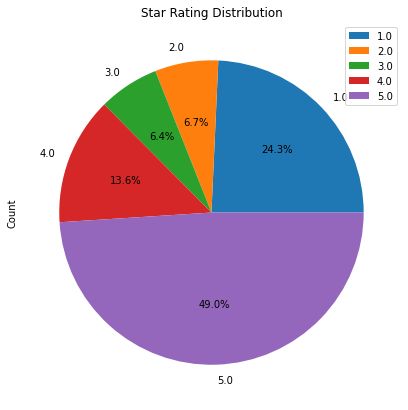

In [ ]:
# Visualize distribution of star ratings
new_df = train_data.groupby(['stars']).count()[['review_id']].rename(columns = {'review_id': 'Count'})
new_df.plot.pie(y = 'Count', autopct='%1.1f%%', figsize = (7,7), title = 'Star Rating Distribution')

In [ ]:
# tokenize reviews
df = train_data.copy()[['text', 'stars']]
mini_df = df[1:10]
mini_df

,text,stars
1,"Kyle did a fantastic job. For starters, you ca...",5.0
2,In a way I'm glad for all the low reviews here...,4.0
3,"The worst Uhaul location in the country, they ...",1.0
4,"I've been coming here for about 2 years, and I...",5.0
5,Great service! We're visiting from The States ...,5.0
6,Wow! Awesome service and professionalism! Afte...,5.0
7,I have to say my experience from beginning to ...,5.0
8,"Drove by saw this new shop, decide to eat here...",1.0
9,I love this target! The store is always clean ...,5.0


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['I', 'is',])
import string
!pip install contractions
import contractions

# expand contractions
mini_df['cleaned'] = mini_df['text'].str.lower().apply(contractions.fix)

# remove stop words
mini_df['cleaned'] = mini_df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# remove numbers + escape characters
mini_df['cleaned'] = mini_df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

# remove punctuation
mini_df['cleaned'] = mini_df['cleaned'].apply(lambda x: ''.join([item for item in x if item not in string.punctuation]))

# tokenize after cleaning
mini_df['tokenized'] = mini_df['cleaned'].apply(nltk.word_tokenize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
mini_df

,text,stars,cleaned,tokenized
1,"Kyle did a fantastic job. For starters, you ca...",5.0,kyle fantastic schedule appointment completely...,"[kyle, fantastic, schedule, appointment, compl..."
2,In a way I'm glad for all the low reviews here...,4.0,way glad low reviews keeps crowd actually one ...,"[way, glad, low, reviews, keeps, crowd, actual..."
3,"The worst Uhaul location in the country, they ...",1.0,worst uhaul location lie put fuel believe some...,"[worst, uhaul, location, lie, put, fuel, belie..."
4,"I've been coming here for about 2 years, and I...",5.0,coming great haircut every hands best value ha...,"[coming, great, haircut, every, hands, best, v..."
5,Great service! We're visiting from The States ...,5.0,great visiting states friend cracked screen fr...,"[great, visiting, states, friend, cracked, scr..."
6,Wow! Awesome service and professionalism! Afte...,5.0,awesome service scheduling week due crazy guys...,"[awesome, service, scheduling, week, due, craz..."
7,I have to say my experience from beginning to ...,5.0,say experience beginning end nothing less comi...,"[say, experience, beginning, end, nothing, les..."
8,"Drove by saw this new shop, decide to eat here...",1.0,drove saw new decide eat middle black hair stu...,"[drove, saw, new, decide, eat, middle, black, ..."
9,I love this target! The store is always clean ...,5.0,love store always clean fully staff always sup...,"[love, store, always, clean, fully, staff, alw..."


In [ ]:
# function to clean + tokenize text reviews
def clean_data(df):
  df = df.copy()[['text', 'stars']]

  # expand contractions
  df['cleaned'] = df['text'].str.lower().apply(contractions.fix)

  # remove stop words
  df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

  # remove numbers + escape characters
  df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

  # remove punctuation
  df['cleaned'] = df['cleaned'].apply(lambda x: ''.join([item for item in x if item not in string.punctuation]))

  # tokenize after cleaning
  df['tokenized'] = df['cleaned'].apply(nltk.word_tokenize)

  return df[['text', 'stars', 'tokenized']]

cleaned_data = clean_data(mini_df)

In [ ]:
cleaned_data

,text,stars,tokenized
1,"Kyle did a fantastic job. For starters, you ca...",5.0,"[kyle, fantastic, schedule, appointment, compl..."
2,In a way I'm glad for all the low reviews here...,4.0,"[way, glad, low, reviews, keeps, crowd, actual..."
3,"The worst Uhaul location in the country, they ...",1.0,"[worst, uhaul, location, lie, put, fuel, belie..."
4,"I've been coming here for about 2 years, and I...",5.0,"[coming, great, haircut, every, hands, best, v..."
5,Great service! We're visiting from The States ...,5.0,"[great, visiting, states, friend, cracked, scr..."
6,Wow! Awesome service and professionalism! Afte...,5.0,"[awesome, service, scheduling, week, due, craz..."
7,I have to say my experience from beginning to ...,5.0,"[say, experience, beginning, end, nothing, les..."
8,"Drove by saw this new shop, decide to eat here...",1.0,"[drove, saw, new, decide, eat, middle, black, ..."
9,I love this target! The store is always clean ...,5.0,"[love, store, always, clean, fully, staff, alw..."


In [ ]:
# stemming/lemmatization (change words to base words)

import nltk
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# function from link in comment
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence, ' '.join(lemmatized_sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
results = mini_df['tokenized'].apply(lemmatize_sentence)
mini_df['stemmed'] = list(zip(*results))[0]
mini_df['stemmed_clean'] = list(zip(*results))[1]
mini_df[['text', 'stars', 'stemmed_clean']].to_csv("lemma_tokenizeddf.csv")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [ ]:
mini_df

,text,stars,cleaned,tokenized,stemmed,stemmed_clean
1,"Kyle did a fantastic job. For starters, you ca...",5.0,kyle fantastic schedule appointment completely...,"[kyle, fantastic, schedule, appointment, compl...","[kyle, fantastic, schedule, appointment, compl...",kyle fantastic schedule appointment completely...
2,In a way I'm glad for all the low reviews here...,4.0,way glad low reviews keeps crowd actually one ...,"[way, glad, low, reviews, keeps, crowd, actual...","[way, glad, low, review, keep, crowd, actually...",way glad low review keep crowd actually one fa...
3,"The worst Uhaul location in the country, they ...",1.0,worst uhaul location lie put fuel believe some...,"[worst, uhaul, location, lie, put, fuel, belie...","[bad, uhaul, location, lie, put, fuel, believe...",bad uhaul location lie put fuel believe someth...
4,"I've been coming here for about 2 years, and I...",5.0,coming great haircut every hands best value ha...,"[coming, great, haircut, every, hands, best, v...","[come, great, haircut, every, hand, best, valu...",come great haircut every hand best value hair cut
5,Great service! We're visiting from The States ...,5.0,great visiting states friend cracked screen fr...,"[great, visiting, states, friend, cracked, scr...","[great, visit, state, friend, crack, screen, f...",great visit state friend crack screen freak ca...
6,Wow! Awesome service and professionalism! Afte...,5.0,awesome service scheduling week due crazy guys...,"[awesome, service, scheduling, week, due, craz...","[awesome, service, schedule, week, due, crazy,...",awesome service schedule week due crazy guy sh...
7,I have to say my experience from beginning to ...,5.0,say experience beginning end nothing less comi...,"[say, experience, beginning, end, nothing, les...","[say, experience, begin, end, nothing, less, c...",say experience begin end nothing less come war...
8,"Drove by saw this new shop, decide to eat here...",1.0,drove saw new decide eat middle black hair stu...,"[drove, saw, new, decide, eat, middle, black, ...","[drive, saw, new, decide, eat, middle, black, ...",drive saw new decide eat middle black hair sti...
9,I love this target! The store is always clean ...,5.0,love store always clean fully staff always sup...,"[love, store, always, clean, fully, staff, alw...","[love, store, always, clean, fully, staff, alw...",love store always clean fully staff always sup...


In [ ]:
#path = "/content/drive/MyDrive/182_nlp/lemma_tokenizeddf.csv"
path = "/dataframes/lemma_tokenizeddf.csv"
cleaned_data = pd.read_csv(path)
cleaned_data.head()

,Unnamed: 0,text,stars,cleaned,tokenized,stemmed,stemmed_clean
0,0,Sam has twice come to my office. First it was...,5.0,sam twice come first repair fairly large repai...,"['sam', 'twice', 'come', 'first', 'repair', 'f...","['sam', 'twice', 'come', 'first', 'repair', 'f...",sam twice come first repair fairly large repai...
1,1,I have 3 chronically ill children and setting ...,5.0,chronically ill children setting appointments ...,"['chronically', 'ill', 'children', 'setting', ...","['chronically', 'ill', 'child', 'set', 'appoin...",chronically ill child set appointment always n...
2,2,"Although prices were right, I was a bit disapp...",3.0,although prices bit disappointed experience we...,"['although', 'prices', 'bit', 'disappointed', ...","['although', 'price', 'bit', 'disappointed', '...",although price bit disappointed experience go ...
3,3,NOT happy with the service at all. I took my w...,1.0,happy service took watch get new battery picke...,"['happy', 'service', 'took', 'watch', 'get', '...","['happy', 'service', 'take', 'watch', 'get', '...",happy service take watch get new battery pick ...
4,4,Raelyn is the best waxer ever! I have been com...,5.0,raelyn best waxer coming years absolute fun pe...,"['raelyn', 'best', 'waxer', 'coming', 'years',...","['raelyn', 'best', 'waxer', 'come', 'year', 'a...",raelyn best waxer come year absolute fun perso...


Run Roberta on dataset https://pytorch.org/hub/pytorch_fairseq_roberta/

In [ ]:
!pip install transformers
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [ ]:
from transformers import RobertaModel

class CustomRobertatModel(nn.Module):
    def __init__(self,num_labels):
        super(CustomRobertatModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(.05)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)        
        return logits
      

In [ ]:
def preprocess_data(df, output_name):
  cleaned_data = clean_data(df)

  results = cleaned_data['tokenized'].apply(lemmatize_sentence)
  cleaned_data['stemmed'] = list(zip(*results))[0]
  cleaned_data['stemmed_clean'] = list(zip(*results))[1]
  cleaned_data[['text', 'stars', 'stemmed_clean']].to_csv(output_name)


In [ ]:
def json_to_csv(file_path):
  data = []
  with open(file_path, 'r', encoding='utf-8') as f:
    for item in jsonlines.Reader(f):
      data.append(item)
      raw_data_df = pd.DataFrame(data)

  raw_df = pd.read_json(path_or_buf=file_path, lines=True)
  raw_df['tokenized_sents'] = raw_data_df['text'].apply(nltk.word_tokenize)
  raw_df.to_csv("tokenized_raw_data_df.csv")

In [ ]:
train_stemmed = cleaned_data[['text', 'stars', 'stemmed_clean']]
train_stemmed.to_csv('training_stemmed.csv')

In [ ]:
# clean and stem augmented review
#path = "/content/drive/MyDrive/182_nlp/aug_threes.csv"
path = "/dataframes/lemma_tokenizeddf.csv"
aug_threes = pd.read_csv(path).iloc[:5158]
aug_threes.head()

,text,stars
0,"Although prices were right, I was a bit disapp...",3
1,Food not Mexican average on. These were nice p...,3
2,Had their burrito steak the Year Down field Up...,3
3,Good pretty! After having lunch and drinks som...,3
4,Stopped off for a drink and a late lunch. ?? T...,3


In [ ]:
#path = "/content/drive/MyDrive/182_nlp/aug_twos.csv"
path = "/dataframes/aug_twos.csv"
aug_twos = pd.read_csv(path).iloc[:1550]
aug_twos.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,text,stars
0,"The food was over cooked <unk> too expensive, ...",2
1,"Ordered and Cali octopus bowls, I still don ' ...",2
2,That after you guys read this you too might wo...,2
3,"Smoke filled and, c enclosed can, many are rep...",2
4,My I fiance to really this great place out qui...,2


In [ ]:
preprocess_data(aug_twos, 'aug_twos_stemmed.csv')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
preprocess_data(aug_threes, 'aug_threes_stemmed.csv')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
